In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

#import keras_contrib.losses.dssim as ssim

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 512
im_height = 512
border = 5
path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample/'

In [3]:
def get_data(path):
    ids_x = next(os.walk(path + "TRM"))[2]
    ids_x.sort()
    ids_y = next(os.walk(path + "RGB"))[2]
    ids_y.sort()
    X = np.zeros((len(ids_x), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids_y), im_height, im_width, 1), dtype=np.float32)
    
    for n, id_x in tqdm_notebook(enumerate(ids_x), total=len(ids_x)):
        id_y = ids_y[n]
        # Load images
        #img = load_img(path + '/TRM/' + id_x, grayscale=True)
        #x_img = img_to_array(img)
        img = cv.imread(path + '/TRM/' + id_x,cv.COLOR_BGR2GRAY)
        x_img = np.array(img)
        x_img = (x_img - x_img.min()) / (x_img.max() - x_img.min())
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/RGB/' + id_y, grayscale=True))
        mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        
        X[n, ..., 0] = x_img.squeeze()
        y[n] = mask / 255
        
    return X, y


X,y = get_data(path_train)


/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/2, random_state=2019)

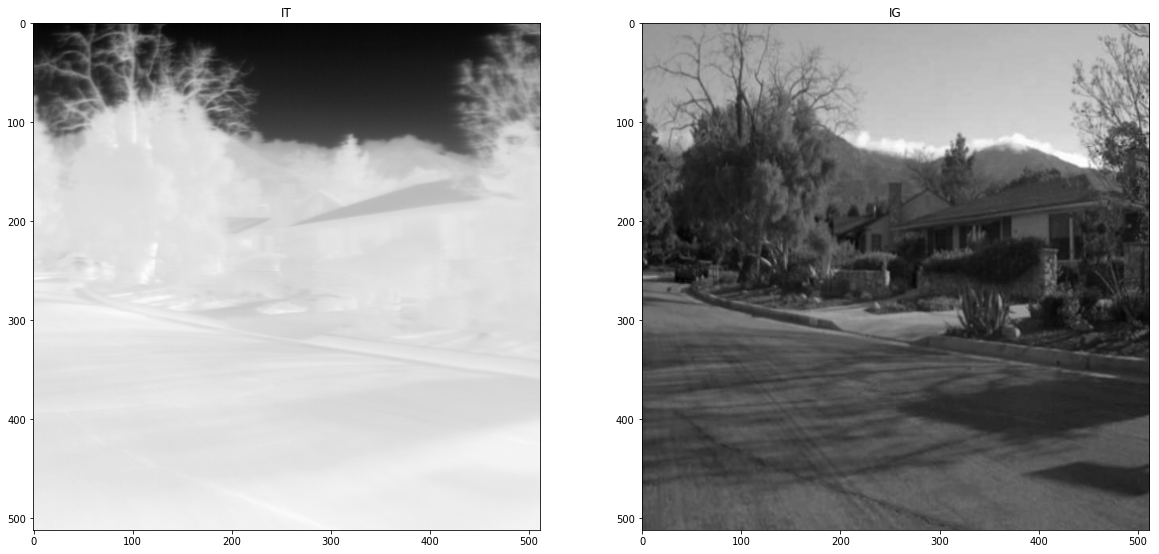

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(X_train)-1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix].squeeze(), cmap='gray', interpolation='bilinear')
ax[0].set_title('IT')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('IG');

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [30]:
def get_unet(input_img, n_filters=4, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p5 = MaxPooling2D((2, 2)) (c5)
    p5 = Dropout(dropout)(p5)
    
    c6 = conv2d_block(p5, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p6 = MaxPooling2D((2, 2)) (c6)
    p6 = Dropout(dropout)(p6)
    
    c7 = conv2d_block(p6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p7 = MaxPooling2D((2, 2)) (c7)
    p7 = Dropout(dropout)(p7)
    
    c8 = conv2d_block(p7, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p8 = MaxPooling2D((2, 2)) (c8)
    p8 = Dropout(dropout)(p8)
    
    c9 = conv2d_block(p8, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    p9 = MaxPooling2D((2, 2)) (c9)
    p9 = Dropout(dropout)(p9)
    
    c10 = conv2d_block(p9, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u9 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c10)
    u9 = concatenate([u9, c9])
    u9 = Dropout(dropout)(u9)
    d9 = conv2d_block(u9, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (d9)
    u8 = concatenate([u8, c8])
    u8 = Dropout(dropout)(u8)
    d8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (d8)
    u7 = concatenate([u7, c7])
    u7 = Dropout(dropout)(u7)
    d7 = conv2d_block(u7, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u6 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (d7)
    u6 = concatenate([u6, c6], axis=3)
    u6 = Dropout(dropout)(u6)
    d6 = conv2d_block(u6, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u5 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (d6)
    u5 = concatenate([u5, c5], axis=3)
    u5 = Dropout(dropout)(u5)
    d5 = conv2d_block(u5, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    
    u4 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (d5)
    u4 = concatenate([u4, c4], axis=3)
    u4 = Dropout(dropout)(u4)
    d4 = conv2d_block(u4, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u3 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (d4)
    u3 = concatenate([u3, c3], axis=3)
    u3 = Dropout(dropout)(u3)
    d3 = conv2d_block(u3, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    
    u2 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (d3)
    u2 = concatenate([u2, c2], axis=3)
    u2 = Dropout(dropout)(u2)
    d2 = conv2d_block(u2, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    u1 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (d2)
    u1 = concatenate([u1, c1], axis=3)
    u1 = Dropout(dropout)(u1)
    d1 = conv2d_block(u1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='relu') (d1)
    #outputs = Conv2D(1, (1, 1)) (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [31]:
def ssim_tf(ssim_fact=1):
    def ssim_loss(y_true, y_pred):
        return K.abs(ssim_fact * tf.image.ssim(y_true, y_pred, max_val=1) + (1-ssim_fact) * mean_absolute_error(y_true, y_pred))
    return ssim_loss

In [43]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.00, batchnorm=True)
ssimTF = ssim_tf(ssim_fact=0)
# 'mean_squared_error' 'mean_absolute_error' 'mean_absolute_percentage_error'
model.compile(optimizer=Adam(), loss=ssimTF, metrics=["accuracy"])
# model.summary()

In [44]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     horizontal_flip=True,
                    rotation_range=15,
                    brightness_range=(0.8, 1.2),
                    zoom_range=[0.7, 1.3])

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2019
bs = 1

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

In [45]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [46]:
#results = model.fit(X_train, y_train, batch_size=1, epochs=30, callbacks=callbacks)
results = model.fit(X_train, y_train, batch_size=1, epochs=300, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))
#results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=30, callbacks=callbacks,
#                              validation_data=(X_valid, y_valid), verbose=2)

Train on 1 samples, validate on 1 samples
Epoch 1/300
1/1 [==============================] - 18s 18s/step - loss: 0.4401 - acc: 0.0000e+00 - val_loss: 0.5328 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.53277, saving model to model-tgs-salt.h5
Epoch 2/300
1/1 [==============================] - 3s 3s/step - loss: 0.3790 - acc: 0.0000e+00 - val_loss: 0.4906 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.53277 to 0.49059, saving model to model-tgs-salt.h5
Epoch 3/300
1/1 [==============================] - 3s 3s/step - loss: 0.3210 - acc: 0.0000e+00 - val_loss: 0.4774 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.49059 to 0.47738, saving model to model-tgs-salt.h5
Epoch 4/300
1/1 [==============================] - 3s 3s/step - loss: 0.2861 - acc: 0.0000e+00 - val_loss: 0.4691 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.47738 to 0.46909, saving model to model-tgs-salt.h5
Epoch 5/300
1/1 [==============================] - 3

Epoch 37/300
1/1 [==============================] - 3s 3s/step - loss: 0.2172 - acc: 0.0000e+00 - val_loss: 0.2254 - val_acc: 0.0000e+00

Epoch 00037: val_loss improved from 0.22673 to 0.22538, saving model to model-tgs-salt.h5
Epoch 38/300
1/1 [==============================] - 3s 3s/step - loss: 0.2164 - acc: 0.0000e+00 - val_loss: 0.2240 - val_acc: 0.0000e+00

Epoch 00038: val_loss improved from 0.22538 to 0.22401, saving model to model-tgs-salt.h5
Epoch 39/300
1/1 [==============================] - 3s 3s/step - loss: 0.2157 - acc: 0.0000e+00 - val_loss: 0.2226 - val_acc: 0.0000e+00

Epoch 00039: val_loss improved from 0.22401 to 0.22258, saving model to model-tgs-salt.h5
Epoch 40/300
1/1 [==============================] - 3s 3s/step - loss: 0.2149 - acc: 0.0000e+00 - val_loss: 0.2211 - val_acc: 0.0000e+00

Epoch 00040: val_loss improved from 0.22258 to 0.22111, saving model to model-tgs-salt.h5
Epoch 41/300
1/1 [==============================] - 3s 3s/step - loss: 0.2141 - acc: 0.0


Epoch 00073: val_loss improved from 0.19908 to 0.19884, saving model to model-tgs-salt.h5
Epoch 74/300
1/1 [==============================] - 3s 3s/step - loss: 0.1942 - acc: 0.0000e+00 - val_loss: 0.1986 - val_acc: 0.0000e+00

Epoch 00074: val_loss improved from 0.19884 to 0.19862, saving model to model-tgs-salt.h5
Epoch 75/300
1/1 [==============================] - 3s 3s/step - loss: 0.1940 - acc: 0.0000e+00 - val_loss: 0.1984 - val_acc: 0.0000e+00

Epoch 00075: val_loss improved from 0.19862 to 0.19842, saving model to model-tgs-salt.h5
Epoch 76/300
1/1 [==============================] - 3s 3s/step - loss: 0.1937 - acc: 0.0000e+00 - val_loss: 0.1982 - val_acc: 0.0000e+00

Epoch 00076: val_loss improved from 0.19842 to 0.19822, saving model to model-tgs-salt.h5
Epoch 77/300
1/1 [==============================] - 3s 3s/step - loss: 0.1934 - acc: 0.0000e+00 - val_loss: 0.1980 - val_acc: 0.0000e+00

Epoch 00077: val_loss improved from 0.19822 to 0.19804, saving model to model-tgs-salt.


Epoch 00109: val_loss improved from 0.19540 to 0.19534, saving model to model-tgs-salt.h5
Epoch 110/300
1/1 [==============================] - 3s 3s/step - loss: 0.1844 - acc: 0.0000e+00 - val_loss: 0.1953 - val_acc: 0.0000e+00

Epoch 00110: val_loss improved from 0.19534 to 0.19528, saving model to model-tgs-salt.h5
Epoch 111/300
1/1 [==============================] - 3s 3s/step - loss: 0.1842 - acc: 0.0000e+00 - val_loss: 0.1952 - val_acc: 0.0000e+00

Epoch 00111: val_loss improved from 0.19528 to 0.19522, saving model to model-tgs-salt.h5
Epoch 112/300
1/1 [==============================] - 3s 3s/step - loss: 0.1840 - acc: 0.0000e+00 - val_loss: 0.1952 - val_acc: 0.0000e+00

Epoch 00112: val_loss improved from 0.19522 to 0.19516, saving model to model-tgs-salt.h5
Epoch 113/300
1/1 [==============================] - 3s 3s/step - loss: 0.1837 - acc: 0.0000e+00 - val_loss: 0.1951 - val_acc: 0.0000e+00

Epoch 00113: val_loss improved from 0.19516 to 0.19509, saving model to model-tgs-s


Epoch 00145: val_loss improved from 0.18938 to 0.18912, saving model to model-tgs-salt.h5
Epoch 146/300
1/1 [==============================] - 3s 3s/step - loss: 0.1772 - acc: 0.0000e+00 - val_loss: 0.1889 - val_acc: 0.0000e+00

Epoch 00146: val_loss improved from 0.18912 to 0.18885, saving model to model-tgs-salt.h5
Epoch 147/300
1/1 [==============================] - 3s 3s/step - loss: 0.1771 - acc: 0.0000e+00 - val_loss: 0.1886 - val_acc: 0.0000e+00

Epoch 00147: val_loss improved from 0.18885 to 0.18858, saving model to model-tgs-salt.h5
Epoch 148/300
1/1 [==============================] - 3s 3s/step - loss: 0.1769 - acc: 0.0000e+00 - val_loss: 0.1883 - val_acc: 0.0000e+00

Epoch 00148: val_loss improved from 0.18858 to 0.18832, saving model to model-tgs-salt.h5
Epoch 149/300
1/1 [==============================] - 3s 3s/step - loss: 0.1767 - acc: 0.0000e+00 - val_loss: 0.1881 - val_acc: 0.0000e+00

Epoch 00149: val_loss improved from 0.18832 to 0.18805, saving model to model-tgs-s


Epoch 00181: val_loss improved from 0.17963 to 0.17938, saving model to model-tgs-salt.h5
Epoch 182/300
1/1 [==============================] - 3s 3s/step - loss: 0.1709 - acc: 0.0000e+00 - val_loss: 0.1791 - val_acc: 0.0000e+00

Epoch 00182: val_loss improved from 0.17938 to 0.17913, saving model to model-tgs-salt.h5
Epoch 183/300
1/1 [==============================] - 3s 3s/step - loss: 0.1707 - acc: 0.0000e+00 - val_loss: 0.1789 - val_acc: 0.0000e+00

Epoch 00183: val_loss improved from 0.17913 to 0.17888, saving model to model-tgs-salt.h5
Epoch 184/300
1/1 [==============================] - 3s 3s/step - loss: 0.1705 - acc: 0.0000e+00 - val_loss: 0.1786 - val_acc: 0.0000e+00

Epoch 00184: val_loss improved from 0.17888 to 0.17864, saving model to model-tgs-salt.h5
Epoch 185/300
1/1 [==============================] - 3s 3s/step - loss: 0.1703 - acc: 0.0000e+00 - val_loss: 0.1784 - val_acc: 0.0000e+00

Epoch 00185: val_loss improved from 0.17864 to 0.17841, saving model to model-tgs-s


Epoch 00217: val_loss improved from 0.17289 to 0.17280, saving model to model-tgs-salt.h5
Epoch 218/300
1/1 [==============================] - 3s 3s/step - loss: 0.1641 - acc: 0.0000e+00 - val_loss: 0.1727 - val_acc: 0.0000e+00

Epoch 00218: val_loss improved from 0.17280 to 0.17271, saving model to model-tgs-salt.h5
Epoch 219/300
1/1 [==============================] - 3s 3s/step - loss: 0.1639 - acc: 0.0000e+00 - val_loss: 0.1726 - val_acc: 0.0000e+00

Epoch 00219: val_loss improved from 0.17271 to 0.17262, saving model to model-tgs-salt.h5
Epoch 220/300
1/1 [==============================] - 3s 3s/step - loss: 0.1638 - acc: 0.0000e+00 - val_loss: 0.1725 - val_acc: 0.0000e+00

Epoch 00220: val_loss improved from 0.17262 to 0.17254, saving model to model-tgs-salt.h5
Epoch 221/300
1/1 [==============================] - 3s 3s/step - loss: 0.1636 - acc: 0.0000e+00 - val_loss: 0.1725 - val_acc: 0.0000e+00

Epoch 00221: val_loss improved from 0.17254 to 0.17246, saving model to model-tgs-s


Epoch 00253: val_loss improved from 0.16911 to 0.16898, saving model to model-tgs-salt.h5
Epoch 254/300
1/1 [==============================] - 3s 3s/step - loss: 0.1599 - acc: 0.0000e+00 - val_loss: 0.1688 - val_acc: 0.0000e+00

Epoch 00254: val_loss improved from 0.16898 to 0.16885, saving model to model-tgs-salt.h5
Epoch 255/300
1/1 [==============================] - 3s 3s/step - loss: 0.1598 - acc: 0.0000e+00 - val_loss: 0.1687 - val_acc: 0.0000e+00

Epoch 00255: val_loss improved from 0.16885 to 0.16872, saving model to model-tgs-salt.h5
Epoch 256/300
1/1 [==============================] - 3s 3s/step - loss: 0.1598 - acc: 0.0000e+00 - val_loss: 0.1686 - val_acc: 0.0000e+00

Epoch 00256: val_loss improved from 0.16872 to 0.16858, saving model to model-tgs-salt.h5
Epoch 257/300
1/1 [==============================] - 3s 3s/step - loss: 0.1597 - acc: 0.0000e+00 - val_loss: 0.1684 - val_acc: 0.0000e+00

Epoch 00257: val_loss improved from 0.16858 to 0.16845, saving model to model-tgs-s


Epoch 00289: val_loss improved from 0.16444 to 0.16432, saving model to model-tgs-salt.h5
Epoch 290/300
1/1 [==============================] - 3s 3s/step - loss: 0.1572 - acc: 0.0000e+00 - val_loss: 0.1642 - val_acc: 0.0000e+00

Epoch 00290: val_loss improved from 0.16432 to 0.16420, saving model to model-tgs-salt.h5
Epoch 291/300
1/1 [==============================] - 3s 3s/step - loss: 0.1571 - acc: 0.0000e+00 - val_loss: 0.1641 - val_acc: 0.0000e+00

Epoch 00291: val_loss improved from 0.16420 to 0.16409, saving model to model-tgs-salt.h5
Epoch 292/300
1/1 [==============================] - 3s 3s/step - loss: 0.1571 - acc: 0.0000e+00 - val_loss: 0.1640 - val_acc: 0.0000e+00

Epoch 00292: val_loss improved from 0.16409 to 0.16397, saving model to model-tgs-salt.h5
Epoch 293/300
1/1 [==============================] - 3s 3s/step - loss: 0.1570 - acc: 0.0000e+00 - val_loss: 0.1639 - val_acc: 0.0000e+00

Epoch 00293: val_loss improved from 0.16397 to 0.16385, saving model to model-tgs-s

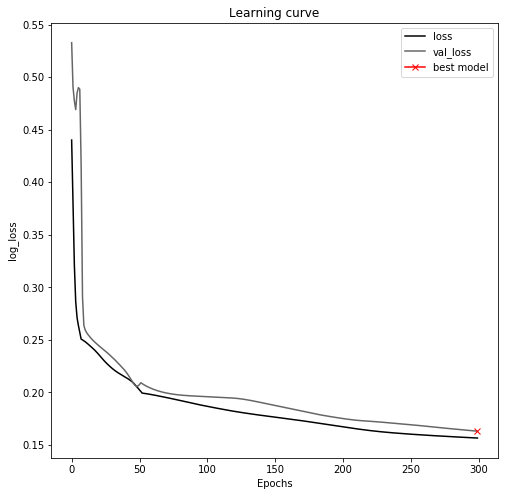

In [47]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [48]:
# Load best model
model.load_weights('model-tgs-salt.h5')


In [49]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 1s 560ms/step


[0.16307565569877625, 0.0]

In [50]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 294ms/step


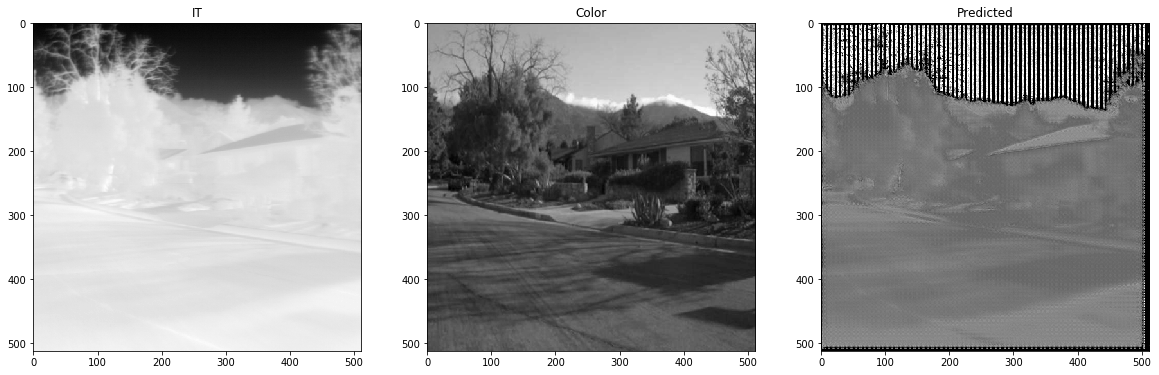

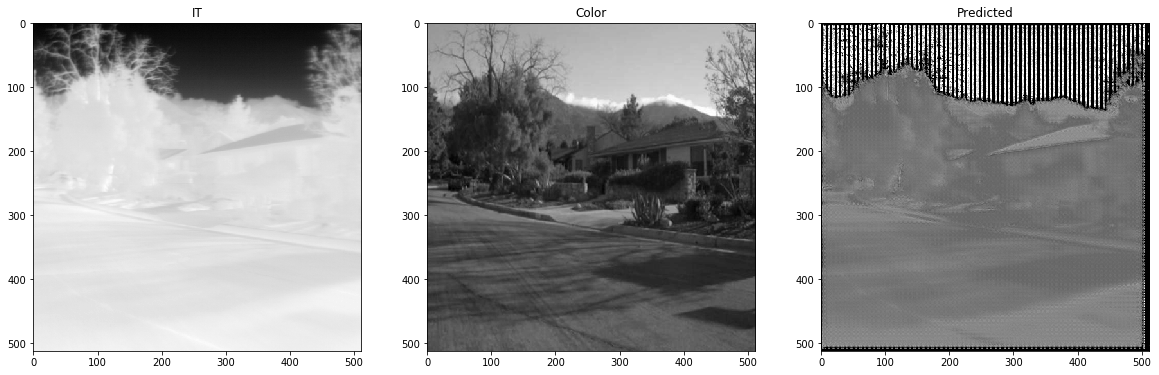

In [51]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X)-1)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    ax[0].set_title('IT')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Color')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted')
    
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)
plot_sample(X_valid, y_valid, preds_val)

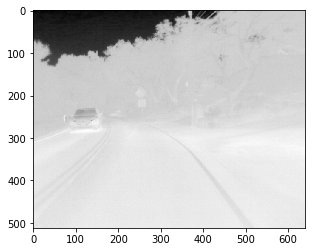

In [17]:
im2 = cv.imread('./IM/TRM/FLIR1.tiff',cv.COLOR_BGR2GRAY)
# im1 = cv2.resize(im1,im2.shape[:2])
imArr = np.array(im2)
imArr = (imArr - imArr.min()) / (imArr.max() - imArr.min())
plt.imshow(imArr);

In [6]:
ids_x = next(os.walk(path_train + "TRM", topdown=True))[2]
ids_y = next(os.walk(path_train + "RGB", topdown=True))[2]
ids_y.sort()
print(ids_y)

StopIteration: 

In [152]:
x = X_train[0,...,0]
im = cv.imdecode(x,1)
equ = cv.equalizeHist(im)
print(im)

None
